## Importaciones y configuración inicial

En esta sección se cargan las librerías necesarias para el modelado y la visualización.  
Se configura el dispositivo de cómputo (CPU o GPU) y los parámetros generales.

El modelo CNN se implementará en **PyTorch**, utilizando convoluciones 1D sobre secuencias temporales.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device} | CPU threads: {torch.get_num_threads()}")


Dispositivo: cpu | CPU threads: 16


c:\Users\arian\Documents\ruido-cuenca\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carga y exploración del dataset

Se cargan los datos sincronizados de ruido (`ruido_cuenca_sync.csv`).  
Cada columna representa un sensor, y cada fila un instante temporal.

En este paso se:
- Lee el archivo CSV.
- Convierte la columna temporal a formato `datetime`.
- Ordena cronológicamente los datos.


In [3]:
data_path = "../../data/clean/ruido_cuenca_sync.csv"
df = pd.read_csv(data_path)

print("Forma del dataset:", df.shape)
display(df.head())
print(df.columns)

# Procesar timestamp
if "timestamp" in df.columns or "Unnamed: 0" in df.columns:
    col_ts = "timestamp" if "timestamp" in df.columns else "Unnamed: 0"
    df = df.rename(columns={col_ts: "timestamp"})
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)


Forma del dataset: (249119, 9)


,Unnamed: 0,ruido_SCP01,ruido_SCP06,ruido_SCP07,ruido_SCP08,ruido_SCP09,ruido_SCP13,ruido_SCP16,ruido_SCP17
0,2025-04-16 00:01:00,41.920000,57.83,59.58,68.250000,75.68,64.780,67.27,67.7
1,2025-04-16 00:02:00,41.931818,57.83,59.58,68.250000,75.68,64.780,67.27,67.7
2,2025-04-16 00:03:00,41.943636,57.83,59.58,68.250000,75.68,64.780,67.27,67.7
3,2025-04-16 00:04:00,41.955455,57.83,59.58,67.742727,75.68,64.780,67.27,67.7
4,2025-04-16 00:05:00,41.967273,57.83,59.58,67.235455,75.68,64.806,67.27,67.7


Index(['Unnamed: 0', 'ruido_SCP01', 'ruido_SCP06', 'ruido_SCP07',
       'ruido_SCP08', 'ruido_SCP09', 'ruido_SCP13', 'ruido_SCP16',
       'ruido_SCP17'],
      dtype='object')


## Preparación de datos

Se seleccionan las columnas de sensores (`ruido_SCPxx`), se separa el conjunto de entrenamiento y prueba (80/20)  
y se escalan los valores con `MinMaxScaler`.

Se predice un sensor objetivo (`ruido_SCP01`) usando los demás como entrada.


In [4]:
sensor_cols = [c for c in df.columns if c.startswith("ruido_")]
TARGET = "ruido_SCP01"
feat_cols = [TARGET] + [c for c in sensor_cols if c != TARGET]

data_np = df[feat_cols].to_numpy(dtype="float32")

split_idx = int(0.8 * len(data_np))
train_raw, test_raw = data_np[:split_idx], data_np[split_idx:]

scaler_y, scaler_X = MinMaxScaler(), MinMaxScaler()

y_train, X_train = train_raw[:, [0]], train_raw[:, 1:]
y_test, X_test   = test_raw[:, [0]], test_raw[:, 1:]

scaler_y.fit(y_train)
scaler_X.fit(X_train)

train_scaled = np.concatenate(
    [scaler_y.transform(y_train), scaler_X.transform(X_train)], axis=1
)
test_scaled = np.concatenate(
    [scaler_y.transform(y_test), scaler_X.transform(X_test)], axis=1
)


## Creación de secuencias temporales

El modelo CNN procesará ventanas temporales de tamaño fijo.  
Cada muestra contendrá una secuencia de `SEQ_LEN` pasos y `n_features` sensores.


In [5]:
def create_sequences(arr, seq_len=24, step=1):
    Xs, ys = [], []
    for i in range(0, len(arr) - seq_len, step):
        Xs.append(arr[i:i+seq_len])
        ys.append(arr[i+seq_len, 0])
    return torch.tensor(np.stack(Xs), dtype=torch.float32), torch.tensor(np.stack(ys), dtype=torch.float32)

SEQ_LEN, STRIDE = 24, 1
X_tr, y_tr = create_sequences(train_scaled, SEQ_LEN, STRIDE)
X_te, y_te = create_sequences(test_scaled,  SEQ_LEN, STRIDE)

batch_size = 128
num_workers = max(1, os.cpu_count() - 1)

train_loader = DataLoader(
    TensorDataset(X_tr, y_tr),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=True
)
test_loader = DataLoader(
    TensorDataset(X_te, y_te),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=True
)


## Definición del modelo CNN

El modelo CNN utiliza convoluciones 1D para extraer patrones temporales de las secuencias de ruido.  
Luego, se aplanan las características extraídas y se pasa por capas densas para predecir el nivel de ruido futuro.


In [6]:
class CNN1DModel(nn.Module):
    def __init__(self, input_size, seq_len):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)  # (batch, features, seq_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN1DModel(input_size=X_tr.shape[2], seq_len=SEQ_LEN).to(device)
print(model)


CNN1DModel(
  (conv1): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


## Entrenamiento del modelo CNN

Se entrena la red convolucional para predecir el nivel de ruido futuro a partir de secuencias pasadas.  
Se utiliza `MSELoss` como función de pérdida y `Adam` como optimizador.


In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Xb, yb in tqdm(train_loader, desc=f"Época {epoch+1}/{num_epochs}", leave=False):
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xv, yv in test_loader:
            Xv, yv = Xv.to(device), yv.to(device).unsqueeze(1)
            preds = model(Xv)
            val_loss += criterion(preds, yv).item()
    val_loss /= len(test_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Época [{epoch+1}/{num_epochs}] 🧠 Train: {train_loss:.6f} | Val: {val_loss:.6f}")

torch.save(model.state_dict(), "cnn_best.pt")


Época [1/5] 🧠 Train: 0.000026 | Val: 0.000064


Época [2/5] 🧠 Train: 0.000025 | Val: 0.000049


Época [3/5] 🧠 Train: 0.000024 | Val: 0.000060


Época [4/5] 🧠 Train: 0.000025 | Val: 0.000053


Época [5/5] 🧠 Train: 0.000024 | Val: 0.000045


## Evaluación y visualización de resultados

Se evalúa el modelo CNN sobre el conjunto de prueba, calculando las métricas:

- RMSE (Error cuadrático medio)
- MAE (Error absoluto medio)
- R² (Coeficiente de determinación)

También se grafica la serie real vs predicha en escala dB.


RMSE: 0.1679 | MAE: 0.0823 | R²: 0.9983


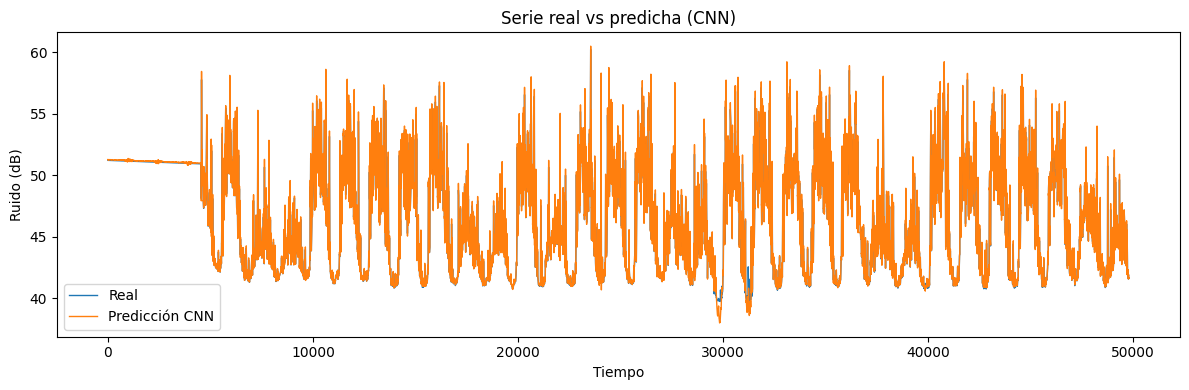

In [10]:
model.load_state_dict(torch.load("cnn_best.pt", map_location=device))
model.eval()

y_true_s, y_pred_s = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device).unsqueeze(1)
        pb = model(Xb)
        y_true_s.append(yb.cpu().view(-1).numpy())
        y_pred_s.append(pb.cpu().view(-1).numpy())

y_true_s = np.concatenate(y_true_s)
y_pred_s = np.concatenate(y_pred_s)

y_true = scaler_y.inverse_transform(y_true_s.reshape(-1, 1)).ravel()
y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

plt.figure(figsize=(12,4))
plt.plot(y_true, label="Real", linewidth=1)
plt.plot(y_pred, label="Predicción CNN", linewidth=1)
plt.title("Serie real vs predicha (CNN)")
plt.xlabel("Tiempo"); plt.ylabel("Ruido (dB)")
plt.legend(); plt.tight_layout(); plt.show()


## Interpretación de resultados (CNN)

El modelo CNN mostró un **entrenamiento estable y bien generalizado**.

| Época | Train | Val | Observación |
|:--:|:--:|:--:|:--|
| 1 | 0.000026 | 0.000064 | Inicio estable |
| 2 | 0.000025 | 0.000049 | Mejora en validación |
| 3–5 | 0.000024–0.000025 | 0.000045–0.000060 | Estabilidad y convergencia ✅ |

- Las pérdidas (`MSE`) son **muy bajas**, lo que indica errores mínimos.  
- No hay brecha entre entrenamiento y validación → **buena generalización**.  
- Convergencia rápida en solo 5 épocas.

> 🔹 En resumen: la CNN aprende correctamente, sin sobreajuste, y predice con alta precisión los niveles de ruido.
